In [ ]:
#Autor: Octavio Osorio Trujillo
#Correo: octavioosoriotrujillo@gmail.com
#Fecha de creación: 24/07/2025
#Última modificación: 27/08/2025
#Descripción: Script para procesar datos de mareógrafico y generar gráficos interactivos
#Versión: 0

In [1]:
!git clone https://github.com/Octavio341/MareograficoGoogleColab.git

Cloning into 'MareograficoGoogleColab'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 333 (delta 40), reused 65 (delta 39), pack-reused 259 (from 1)
Receiving objects: 100% (333/333), 2.77 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [2]:
###########################################################################
#filtro de control de ruido
#stuckData

#       Version 1 A2
###################################
import os
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files, drive
from ipywidgets import HBox, Button, widgets
from IPython.display import display, clear_output, HTML
##################################################
##################  NUEVAS IMPORTACIONES #########
##################################################
import datetime
import numpy as np
from os.path import basename
from pathlib import Path

from bokeh.plotting import figure
from bokeh.io import output_notebook,show,curdoc
from bokeh.embed import components
from bokeh.resources import CDN
from bokeh.models import FixedTicker, Button ,ColumnDataSource, CheckboxGroup, CustomJS, Button as  BokehButton, HoverTool,CrosshairTool,DatetimeTickFormatter, LabelSet,ColumnDataSource,CheckboxGroup,CustomJS,Div
from scipy.interpolate import make_interp_spline
from bokeh.layouts import column,row
from bokeh.events import ButtonClick
import hashlib
#para ejecutar scripts
import subprocess


clear_output()
fixed_height = '2060px' # establecemos un ALTURA fija para los contenidos
fixed_width = '1800px' # establecemos un ANCHO fijo para los contenidos
#le pasamos un los parametros a nuestros widgets
inicio = widgets.Output(layout=widgets.Layout(height=fixed_height,width=fixed_width))
grafica = widgets.Output(layout=widgets.Layout(heigth=fixed_height,width=fixed_width))
archivo_toga = widgets.Output(layout=widgets.Layout(heigth=fixed_height,width=fixed_width))
terminal = widgets.Output(layout=widgets.Layout(heigth=fixed_height,width=fixed_width))
#==== explicacion ======
# les damos un estilo unico y fijo


#############################################################################
archivos_cargados = [] # esto nos sirve para guardar los nombres de los archivos
lista_archivos=[]
# Widgets principales
ruta_archivo=[]

#revisamos si no existe esta ruta
if not os.path.exists('/content/drive'):

  #usamos el modulo drive que conecta a la funcion mount, para asi montar nuestra ruta
  drive.mount('/content/drive')

#guardamos nuestra ruta base en ruta_drive
ruta_drive = '/content/drive/MyDrive'

#mas adelante podemos modificaremos su contenido de forma dinamica
ruta_actual = [ruta_drive]

# nuestra lista general de archivos
rutas_seleccionadas = []

#creamos nuestros contenedores para mostrar resultados
#con Output() creamos una area de salida interactiva, para mostrar errores y cualquier salida
#esto lo mostraremos mas adelante
salida_pc = widgets.Output()
salida_drive = widgets.Output()
salida_resultado = widgets.Output()
output = widgets.Output()
#creamos dos boton que mostara un texto personalizado con estilo 'info'
#esto lo usaremos mas adelante
boton_pc = widgets.Button(description="Desde PC",button_style='info')
boton_drive = widgets.Button(description="Navegar en Drive",button_style='success')

#creamos nuestra funcion para mostrar el contenido seleccionado desde drive
def mostrar_contenido_drive():
  #usamos nuestro contenedor para mostrar el contenido que continua
  with salida_drive:
    #eliminamos todo lo anterior
    clear_output()
    print("Has seleccionado",rutas_seleccionadas)
    print("Rutas Guardadas",ruta_archivo)
    #obtenemos el primer elemento de la lista
    actual = ruta_actual[0]
    #listamos todas las carpetas(al igual que archivos) y las guardamos en archivos
    archivos = os.listdir(actual)


    #para cada elemento f  en la lista de archivos, si f es uan carpeta dentro de la ruta actual
    #agregar f a la lista de carpetas
    carpetas = sorted([f for f in archivos if os.path.isdir(os.path.join(actual,f))])

    #para cada elemento en la lista de archivos, si es un archivo agregalos a unalista
    #sorted nos ayuda a optener un alfabeticamente la lista interna y esa lista lo guardamos en ficheros
    ficheros = sorted([f for f in archivos if os.path.isfile(os.path.join(actual,f))])

    #cremos un widget de seleccion multiple
    #esto mostrara todos los archivos y podemos seleccionar varios
    selector = widgets.SelectMultiple(
        #unir las listas de carpetas y ficheros
        options = carpetas + ficheros,
        #agregamos una etiqueta de contenido
        description = 'Contenido:',
        #mostrar hasta 10 filas visibles a la vez
        rows = 10,
        #ajustamos el ancho del widget al 80%
        layout = widgets.Layout(width='80')
    )
    #creamos nuestros botones
    boton_entrar = widgets.Button(description="<Entrar a carpeta>")
    boton_atras = widgets.Button(description="<--Ir atras")
    boton_seleccionar = widgets.Button(description = ">> Seleccionar archivo <<")

    #creamos nuestra funcion al hacer click en una carpeta
    def entrar_click(b):
      # leemos lo que el usuario ya ha seleccionado desde el widget en selector
      #convertimos esa seleccion en unalista y lo guardamos en la variable seleccion
      seleccion = list(selector.value)
      # si la cantidad de elementos seleccionados es = a 1, hacer lo siguiente
      if len(seleccion) ==1:
        #le asignamos a la variable nombre el primer elemento seleccionado
        nombre= seleccion[0]
        #recordemos que el ruta actual esta como  '/content/drive/MyDrive'
        #entonces le pasamos el nombre del archivo seleccionado
        #nueva ruta = tiene ahora la ruta del archivo seleccionado
        nueva_ruta = os.path.join(actual,nombre)

        #si la ruta guardada en 'nueva_ruta'es una carpeta
        #nueva_ruta = es igual al archivo seleccionado
        if os.path.isdir(nueva_ruta):
          # le pasamos la nueva ruta el primer elemento en posicion 0 de la lista de ruta actual
          ruta_actual[0] = nueva_ruta
          # y vamos de nuevo a mostrar el contenido de drive
          mostrar_contenido_drive()
        # y si no es asi pues
        else:
          #mostramos el widget de salida de resultado
          # donde limpiamos y imprimimos un mensaje
          with salida_resultado:
            clear_output()
            print("Solo puedes seleccionar una carpeta a la vez")
      #si no se ha seleccionado uno pues asemos lo siguiente
      else:
        #donde mostramos el siguiente mensaje de salida resultado
        with salida_resultado:
          clear_output()
          print("Solo puedes seleccionar una carpeta para entrar")

    # esto es para cuando hemos seleccionado nuestro boton de ir atras
    # a la funcion le pasamos el parametro b como representacion del boton presionado
    def atras_click(b):
      #preguntamos si ruta actual es diferente a ruta drive
      # si si estonces la condicion se cumple
      if ruta_actual[0] != ruta_drive:
        #cambiamos la ruta actual por {la carpeta anterior}
        ruta_actual[0] = os.path.dirname(ruta_actual[0])
        #de nuevo volvemos a iniciar
        mostrar_contenido_drive()

    # ahora con el boton de seleccionar el archivos
    def seleccionar_click(b):
      #leemos los elementos seleccioados  y con el widget de selector
      # ahora value devuelve los elementos seleccionado de forma tupla
      #('carpeta','archivo1.txt') pero con list lo convertimos en una lista
      seleccionados = list(selector.value)
      #inicializamos una variable
      agregados = 0

      #con la variable nombre recorremos la lista de elementos
      # ejemplo nombre se asigna ra el nombre de cada archivo acumulado en seleccionados
      #nombre = 'archivo.dat'
      for nombre in seleccionados:
        #unimos la ruta actual con nombre que se esta iterando
        #actual es la ruta y en ruta completa se almacenara la ruta general
        ruta_completa = os.path.join(actual,nombre)
        #si existe el archivo en la ruta completa
        if os.path.isfile(ruta_completa):
          #si es asi entonces verificamos si ruta completa no esta en nuestra lista de rutas seleccionadas
          if ruta_completa not in rutas_seleccionadas:
            #si esto se comple
            #agregamos la ruta_completa asta el final de rutas seleccionadas
            rutas_seleccionadas.append(ruta_completa)
            #y incrementamos a agregados
            agregados =+1
          else:
            print("")
            print(f"==> Archivo duplicado (contenido igual){os.path.basename(ruta_completa)} <==")
      #mostramos_rutas() es donde tenemos una funcion que muestra las ruta recien agregadas
      mostrar_rutas()
      #ademas verificamos si agregados fue incrementado
      # es para saber si hubo archivos añadidos
      if agregados == 0:
        print("Ningun archivo nuevo fue agregado")
    #cuando presionemos el boton vamos a entrar a ejecutar sus funciones
    boton_entrar.on_click(entrar_click)
    boton_atras.on_click(atras_click)
    boton_seleccionar.on_click(seleccionar_click)

    #mostramos una caja vertical
    display(widgets.VBox([
        #usamos un texto html que dice ruta actual en negrita
        widgets.HTML(f"<b>Ruta actual:</b>{actual}"),
        #el selector de opcion
        selector,
        #una fila horizontal con los botones atras, entrar y seleccionar
        widgets.HBox([boton_atras,boton_entrar,boton_seleccionar])
    ]))
# un conjunto vacio de coleciones de elementos unico y no ordenados
hashes_archivos = set()

def obtener_hash(archivo_path):
  hash_md5 = hashlib.md5()
  with open(archivo_path, "rb") as f:
    for chunk in iter(lambda:f.read(4096),b""):
      hash_md5.update(chunk)
  return hash_md5.hexdigest()

def seleccionar_desde_pc(b=None):
  with salida_pc:
    clear_output()
    print("Sube un archivo desde tu PC:")
    print("Has seleccionado",rutas_seleccionadas)
    print("Rutas Guardadas",ruta_archivo)
    upload = files.upload()

    for nombre in upload.keys():
      ruta_local = os.path.abspath(nombre)
      hash_archivo = obtener_hash(ruta_local)
      if hash_archivo not in hashes_archivos:
        rutas_seleccionadas.append(ruta_local)
        hashes_archivos.add(hash_archivo)
        print("")
        print(f"==> Archivo añadido:{os.path.basename(ruta_local)} <==")
      else:
        print("")
        print(f"==> Archivo duplicado (contenido igual){os.path.basename(ruta_local)} <==")
        print("")
    mostrar_rutas()

def mostrar_rutas():
    with salida_resultado:
        clear_output()
        if rutas_seleccionadas:
            print("Archivos seleccionados")
            print("")
            for i, ruta in enumerate(rutas_seleccionadas, 1):
                print(f"{i}. {ruta}")
                ruta_archivo.append(ruta)
        else:
            print("No se ha seleccionado ningún archivo aún")
    print("Has seleccionado",rutas_seleccionadas)
def activar_pc(b):
  salida_drive.clear_output()
  salida_resultado.clear_output()
  ruta_actual[0]=ruta_drive
  seleccionar_desde_pc(None)

def activar_drive(b):
  salida_pc.clear_output()
  salida_resultado.clear_output()
  ruta_actual[0]=ruta_drive
  mostrar_contenido_drive()

######################################################################
# =================== FUNCION GRAFICA ================================
 #funcion grafica
def archivo_togas(ruta_archivo):
    print("archivos cargados",archivos_cargados)
    matriz_toga = pd.read_csv(ruta_archivo,sep=r'\s+',names =["StationID", "StationName", "Date", "D1", "D2", "D3","D4", "D5", "D6", "D7", "D8", "D9", "D10", "D11", "D12"], engine = 'python', skiprows = 1, na_values = "9999")
    #print("Matriz toga",matriz_toga.head())
    # version mejorada de google colab
    #display(matriz_toga.head()) # podemos ponerle valore al head(10) conforme a las filas que queremos ver
    display(matriz_toga)  # Muestra todo el DataFrame completo

def graficar_archivo(ruta_archivo):
  # Mostrar interfaz inicial
  lista_archivos = []
  if ruta_archivo: # esto nos sirve para preguntar si se ha seleccionado un archivo
    lista_archivos.append(Path(ruta_archivo).name)

    for nombre_archivo in lista_archivos:
      ya_registrado = False # esto es nuestra bandera, para saber si el archivo a sido agregado

      for nombre22 in archivos_cargados:
        if nombre_archivo == nombre22:
          print("----------------------------------------------------------------------------------------")
          print(f"======  El archivo '{nombre_archivo}'ya ha se ha registrado")
          ya_registrado = True  # marcar como duplicado
          break

      if not ya_registrado:
        archivos_cargados.append(nombre_archivo)
        print("archivos cargados",archivos_cargados)
        matriz_toga = pd.read_csv(ruta_archivo,sep=r'\s+',names =["StationID", "StationName", "Date", "D1", "D2", "D3","D4", "D5", "D6", "D7", "D8", "D9", "D10", "D11", "D12"], engine = 'python', skiprows = 1, na_values = "9999")
        #print("Matriz toga",matriz_toga.head())
        # version mejorada de google colab

        #display(matriz_toga.head(10)) # podemos ponerle valore al head(10) conforme a las filas que queremos ver
        lista_fecha= list()
        lista_datos=list()
        # nueva implementacion
        lista_etiquetas=list()
        lista_datos_no_picos=list()
        lista_fecha_no_picos=list()
        filas_dat=0
        #nueva implementacion con stuckdata
        stucktotal = 0
        stuckcount = 0
        stucklimit = 4

        stuckindex = 0

        lista_stuck_datos=list()
        lista_stuck_fechas=list()

        #incio con el analisis de los registros
        for filas_dat in matriz_toga.index:
          fecha = str(matriz_toga["Date"][filas_dat])

          if fecha[8:9]== "1":
            fecha_inicial = datetime.datetime(int(fecha[:4]),int(fecha[4:6]),int(fecha[6:8]))

          else:
            fecha_inicial = datetime.datetime(int(fecha[:4]),int(fecha[4:6]),int(fecha[6:8]),12)

          for dat in ["D1", "D2", "D3", "D4",  "D5", "D6", "D7", "D8", "D9", "D10", "D11", "D12"]:

            lista_fecha.append(fecha_inicial)
            lista_datos.append(matriz_toga[dat][filas_dat])
            #AGRAGMOS LAS LISTA ETIQUETAS
            lista_etiquetas.append(0)
            fecha_inicial=fecha_inicial+datetime.timedelta(hours=1)
        ######################################################################
          # =================== los datos sin pico  ================================
        filas_dat=0
        stuckvalue = lista_datos[0]

        for filas_dat in range(len(lista_datos)):
          if lista_etiquetas[filas_dat] !=8 and lista_etiquetas[filas_dat]!=3:
            lista_fecha_no_picos.append(lista_fecha[filas_dat])
            lista_datos_no_picos.append(lista_datos[filas_dat])

          ######################################################################
          # =================== los STUCKDATA  ================================
          if filas_dat >0:
            #verificamos si el dato que se esta revisando actualmente no es igual stuckvalue
            if stuckvalue == lista_datos[filas_dat] and filas_dat -1 == stuckindex:
              stuckcount = stuckcount +1
            else:
              stuckcount = 0
            #se comple cuando cuando stuckvalue sea igual a lista_datos y que stuklimit sea menor que stuckcount
            if stuckcount >= stucklimit-1:

              # si se trata de los primeros tres valores, etiquetar los dos valores que siguen
              if stuckcount == stucklimit-1:
                for k in range(filas_dat-(stucklimit-1),filas_dat):
                  lista_etiquetas[k]=3
                  #print("--se han encontrado valores iguales consecutivos (stuck values).valor:" + str(lista_datos[k]) + "posicion:" + str(k))
                  lista_stuck_datos.append(lista_datos[k])
                  lista_stuck_fechas.append(lista_fecha[k])
                stucktotal = stucktotal + 1
              #etiqueta el stuckvalue actual
              lista_etiquetas[filas_dat]=3
              #print("-- se ha encontrado y etiquetado valores iguales consecutivos (stuck values).valor:" + str(lista_datos[filas_dat]) + "posicion:" + str(filas_dat))
              lista_stuck_datos.append(lista_datos[filas_dat])
              lista_stuck_fechas.append(lista_fecha[filas_dat])
            #si no pasa nada solo se le asigna el valor a stuckvalue
            stuckvalue = lista_datos[filas_dat]
            stuckindex = filas_dat
        titulo2 = widgets.HTML("<h3 style='color: teal;'>Graficando</h3>")
        display(titulo2)
        #crear herramientas
        herramientas=[
            "pan",
            "wheel_zoom",
            "box_zoom",
            "reset",
            "save",
            "lasso_select",
            "box_select",
            "tap",
            "zoom_in",
            "zoom_out",
            "help"
        ]
        p = figure(
            title=f"Gráfica del archivo Toga: {lista_archivos}",
            x_axis_label="Fecha",
            y_axis_label="Nivel del mar (mm)",
            x_axis_type="datetime",
            width=1600,
            height=700,
            tools=','.join(herramientas),
            toolbar_location="above",
            toolbar_sticky=False,
            margin=(5, 5, 5, 5)
        )
        #Añadir HoverTool(muestra tooltip con datos exactos al pasar el mouse)
        hover = HoverTool(
            tooltips=[("Fecha", "@x{%F}"), ("Nivel", "@y")],
            formatters={'@x': 'datetime'},
            mode='vline',
            point_policy="follow_mouse",  # sigue el mouse en lugar de flotar
            line_policy="nearest"         # muestra el punto más cercano
        )

        #Añadir CrosshairTool (Muestra lineas guia horizontal y verticales para facilitar lectura)
        crosshair = CrosshairTool(dimensions= 'both')#lineas vertical y horizontal
        p.add_tools(crosshair)

        #creamos la grafica de diferente forma
        # NUESTRO CODIGO DE ZOOM INTERACTIVO
        source1 = ColumnDataSource(data=dict(x=lista_fecha,y=lista_datos))
        source2= ColumnDataSource(data=dict(x=lista_fecha_no_picos,y=lista_datos_no_picos))
        source3= ColumnDataSource(data=dict(x=lista_stuck_fechas,y=lista_stuck_datos))


        x_in = BokehButton(label="<Zoom In X",width=200)
        x_out= BokehButton(label=">Zoom Out X",width=200)

        x_in.js_on_click(CustomJS(args=dict(p=p),code="""
            let range = p.x_range.end - p.x_range.start;
            let center = (p.x_range.start + p.x_range.end) /2;
            let new_range = range * 0.8;
            p.x_range.start =center-new_range/2;
            p.x_range.end = center + new_range/2;
        """))

        x_out.js_on_click(CustomJS(args=dict(p=p),code="""
            let range = p.x_range.end - p.x_range.start;
            let center = (p.x_range.start + p.x_range.end)/2;
            let new_range = range * 1.2;
            p.x_range.start = center -new_range/2;
            p.x_range.end = center + new_range/2;
        """))

        #Botones para Y
        y_in=BokehButton(label="<zoom In Y",width=200)
        y_out=BokehButton(label=">Zoom Out Y",width=200)

        y_in.js_on_click(CustomJS(args=dict(p=p),code="""
            let range = p.y_range.end - p.y_range.start;
            let center = (p.y_range.start + p.y_range.end)/2;
            let new_range = range * 0.8;
            p.y_range.start = center -new_range/2;
            p.y_range.end = center + new_range/2;
        """))

        y_out.js_on_click(CustomJS(args=dict(p=p),code="""
            let range = p.y_range.end - p.y_range.start;
            let center = (p.y_range.start + p.y_range.end)/2;
            let new_range = range *1.2;
            p.y_range.start = center - new_range/2;
            p.y_range.end = center + new_range / 2;
        """))

        #crear la figura
        linea1 = p.line(source=source1, line_width=2, color="blue")
        linea2 = p.line(source=source2, line_width=2, color="red")
        linea3 = p.line(source=source3, line_width=2,color="black")

        #checkbox para mostrar/ ocultar
        checkbox = CheckboxGroup(labels=["Mostrar curva original","Mostrar curva con Ruido","Mostrar StuckData"],active=[0])
        #inicializamos la visibilidad al ejecutar
        linea1.visible= 0 in checkbox.active
        linea2.visible= 1 in checkbox.active
        linea3.visible= 2 in checkbox.active

        #JS para apagar /encender lineas
        callback = CustomJS(args=dict(l1=linea1,l2=linea2,l3=linea3,chk=checkbox),code="""
            l1.visible=chk.active.includes(0);
            l2.visible=chk.active.includes(1);
            l3.visible=chk.active.includes(2);
        """)
        checkbox.js_on_change('active', CustomJS(args=dict(l1=linea1, l2=linea2, l3=linea3, chk=checkbox), code="""
            l1.visible = chk.active.includes(0);
            l2.visible = chk.active.includes(1);
            l3.visible = chk.active.includes(2);
        """))
        #instruccion que detecta el cambio y lo asocia al callback
        checkbox.js_on_change('active',callback)
        p.title.text_font_size = "20pt"
        p.xaxis.axis_label_text_font_size = "16pt"
        p.yaxis.axis_label_text_font_size = "16pt"

        p.add_tools(HoverTool(tooltips=[("Fecha", "@x{%F}"), ("Nivel", "@y")], formatters={'@x': 'datetime'}))
        p.toolbar.logo = None  # Ocultar logo de Bokeh


        #nuestro layout final para el ZOOM INTERACTIVO
        controles_x = row(x_in,x_out)
        controles_y = row(y_in,y_out)

        layout22 = row(p,checkbox)
        layout_final = column(controles_x, controles_y,layout22 )

        # Obtener script y div
        script, div = components(layout_final)

        # Recursos CDN
        recursos = CDN.render()

        # Mostrar todo junto
        html = recursos + div + script
        display(HTML(html))
  else:
    print("No se ha seleccionado ningún archivo.")

def ejecutar_scripts(ruta_archivo):
  scripts = [
        "/content/MareograficoGoogleColab/ET1_ proyecto 1/GENERAL/SCRIPTS -- de practica/06_comprobar_datos_toga.py",
        "/content/MareograficoGoogleColab/ET1_ proyecto 1/GENERAL/SCRIPTS -- de practica/11_control_calidad_automatizado.py"
    ]

  for script in scripts:
      comando = ['python3', script, ruta_archivo]
      print(f"\n--- Ejecutando: {script} ---")
      resultado = subprocess.run(comando, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
      print(resultado.stdout)
      if resultado.stderr:
          print("⚠️ Error:", resultado.stderr)
          print("Verifica que ya hayas llamado el repositorio")
          print("que contiene los scripts")
  print("")
  print("#######################################################################################")
  print("")

#def Iniciar_repositorio(b):
 # !git clone https://github.com/Octavio341/MareograficoGoogleColab.git

# === Crear el botón
boton_mostrar = widgets.Button(description="Mostrar/Ocultar gráfica", button_style='success')
boton_mostrar_Toga = widgets.Button(description="Mostrar/Ocultar Archivo Toga", button_style='info')
boton_mostrar_Terminal = widgets.Button(description="Comenzar analisis", button_style='danger')

# === Contenedor donde irá la gráfica y Toga
salida_grafica = widgets.Output()
salida_Toga = widgets.Output()
salida_terminal = widgets.Output()

# === Variable de control para alternar mostrar/ocultar
mostrar = False
mostrar_Toga = False
mostrar_Terminal = False
###############################################################################
#================== FUNCION DE LAS VENTANAS          =================================
def crear_pestaña():
    #=================================

    #ENVIAMOS CONTENIDO DENTRO DEL WIDGET
    with inicio:
      clear_output()
      #Eventos
      boton_pc.on_click(activar_pc)
      boton_drive.on_click(activar_drive)
      #############################
      # Diseño a los botones
    # Agruparlos en una fila (HBox) y centrar
      hbox_botones = widgets.HBox(
            [boton_pc, boton_drive],
            layout=widgets.Layout(justify_content='center')
        )
      contenedor_central = widgets.VBox(
          [hbox_botones],
          layout=widgets.Layout(
              width='80%',
              height='40px',
              align_items='center',  # centra verticalmente los elementos hijos
              justify_content='center',
              border='0px solid lightgray'
          )

      )
      ###########################################
      # Aplicar margen a cada widget para separarlos
      salida_resultado.layout = widgets.Layout(margin='0 10px 0 0')  # margen derecho
      salida_drive.layout = widgets.Layout(margin='0 10px 0 10px')   # márgenes laterales
      salida_pc.layout = widgets.Layout(margin='0 0 0 10px')          # margen izquierdo

      # Diseño a los salidas
      hbox_botones2 = widgets.HBox(
            [salida_resultado, salida_drive,salida_pc],
            layout=widgets.Layout(justify_content='center')
      )
      contenedor_central2 = widgets.VBox(
          [hbox_botones2],
          layout=widgets.Layout(
              width='100%',
              height='500px',
              align_items='center',  # centra verticalmente los elementos hijos
              border='0px solid lightgray'
          )

      )

      #Mostrar interfaz
      display(widgets.HBox([contenedor_central]))
      display(widgets.HBox([contenedor_central2]))
      #display(salida_pc)
      #display(salida_drive)
      #display(salida_resultado)
    with grafica:
      clear_output()
      # === Mostrar en pantalla
      display(boton_mostrar, salida_grafica)
      print("Grafica",ruta_archivo)

    with archivo_toga:
      clear_output()
      display(boton_mostrar_Toga, salida_Toga)

    with terminal:
      clear_output()
      display(boton_mostrar_Terminal, salida_terminal)

   ###############################################################################
   #==================  ventanas             =================================

    # LAS PESTAÑAS DONDE ESTARAN LA MAYORIA DE LOS CONTENIDOS
    tab = widgets.Tab(children=[inicio,grafica,archivo_toga,terminal])
    tab.set_title(0,'Inicio')
    tab.set_title(1,'Grafica')
    tab.set_title(2,'Archivo -Toga')
    tab.set_title(3,'Terminal')

    ventana_estilizada = widgets.Box([tab],layout=widgets.Layout(
    # caja personalizada
        width= '2000px',#ancho del widgets
        height='1000px',# definemos la altura del contendor
    ))

    # Añadir la clase css al box para aplicar estilos (modificamos clases en la salida HTML)
    ventana_estilizada.add_class('widget-box')# nombre de la clase css
    return ventana_estilizada # de vuelve un widget
################################
##===========Grafica===================
#################################
# === Función del botón
def alternar_grafica(_):
    global mostrar
    mostrar = not mostrar  # alterna entre True y False

    with salida_grafica:
        clear_output()
        if mostrar:
          !cd PruebaconGoogleColab && git pull
          graficar_archivo(ruta_archivo[-1])  # Toma el último archivo

# === Conectar el botón a la función
boton_mostrar.on_click(alternar_grafica)
#====================================
#######################################
################################
##===========Grafica===================
#################################
# === Función del botón
def alternar_Toga(_):
    global mostrar_Toga
    mostrar_Toga = not mostrar_Toga  # alterna entre True y False

    with salida_Toga:
        clear_output()
        if mostrar_Toga:
            archivo_togas(ruta_archivo[-1])  # Toma el último archivo

# === Conectar el botón a la función
boton_mostrar_Toga.on_click(alternar_Toga)
#====================================
#######################################

################################
##===========Grafica===================
#################################
# === Función del botón
def alternar_Terminal(_):
    global mostrar_Terminal
    mostrar_Terminal = not mostrar_Terminal  # alterna entre True y False

    with salida_terminal:
        clear_output()
        if mostrar_Terminal:
            ejecutar_scripts(ruta_archivo[-1])  # Toma el último archivo

# === Conectar el botón a la función
boton_mostrar_Terminal.on_click(alternar_Terminal)
#====================================
#######################################
ventana_principal= crear_pestaña() #llamamos nuestra funcion
display(ventana_principal)# renderiza el widget en la celda de salida

boton_nueva_ventana = widgets.Button(description="Abrir otra ventana")#Guardar el boton interactivo creado
output_ventana = widgets.Output()# se pueden mostrar otra ventana al hacer clic

def abrir_otra_ventana(b): # esto es para cuando hagamos un clic
# cuando hagmos el clic
  with output_ventana: # todo contenido que se imprime dentro
    nueva_ventana = crear_pestaña()# devuelve un box con pestañas o widgets interactivos
    display(nueva_ventana)# se vera debajo del boton

boton_nueva_ventana.on_click(abrir_otra_ventana)
display(boton_nueva_ventana,output_ventana)

print(ruta_archivo)


Mounted at /content/drive


Box(children=(Tab(children=(Output(layout=Layout(height='2060px', width='1800px')), Output(layout=Layout(width…

Button(description='Abrir otra ventana', style=ButtonStyle())

Output()

[]


In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

source = ColumnDataSource(data=dict(
    meses=["Enero", "Febrero", "Marzo"],
    zona_a=[30, 40, 50],
    zona_b=[50, 60, 70],
    zona_c=[20, 30, 40]
))

colores = ["#1f77b4", "#2ca02c", "#ff7f0e"]  # azul, verde, naranja

p = figure(x_range=source.data["meses"], height=350, title="Distribución de Agua por Zona",
           toolbar_location=None, tools="")

p.vbar_stack(["zona_a", "zona_b", "zona_c"], x='meses', width=0.9, color=colores,
             legend_label=["Zona A", "Zona B", "Zona C"], source=source)

p.y_range.start = 0
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)


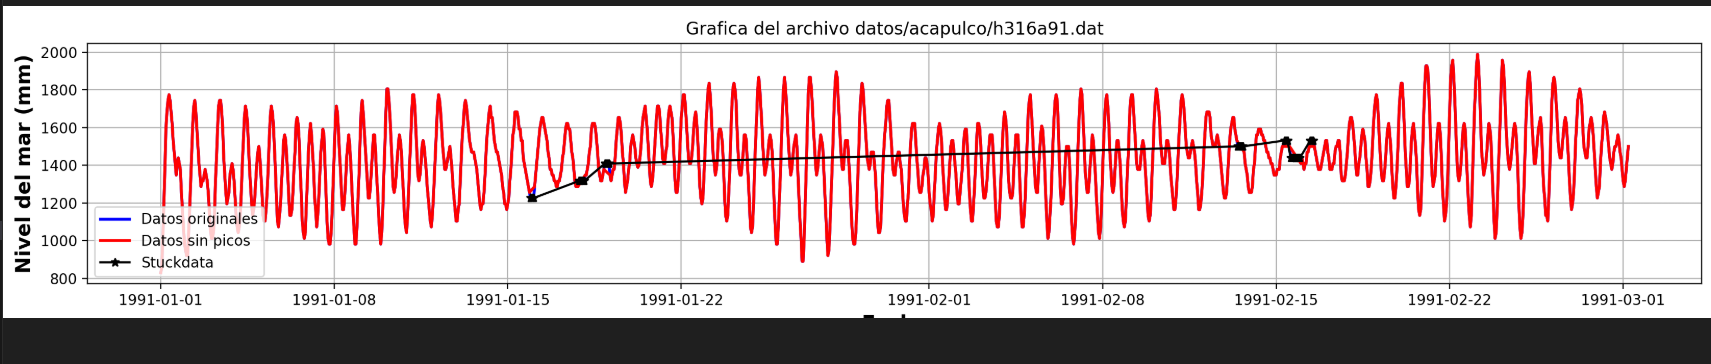

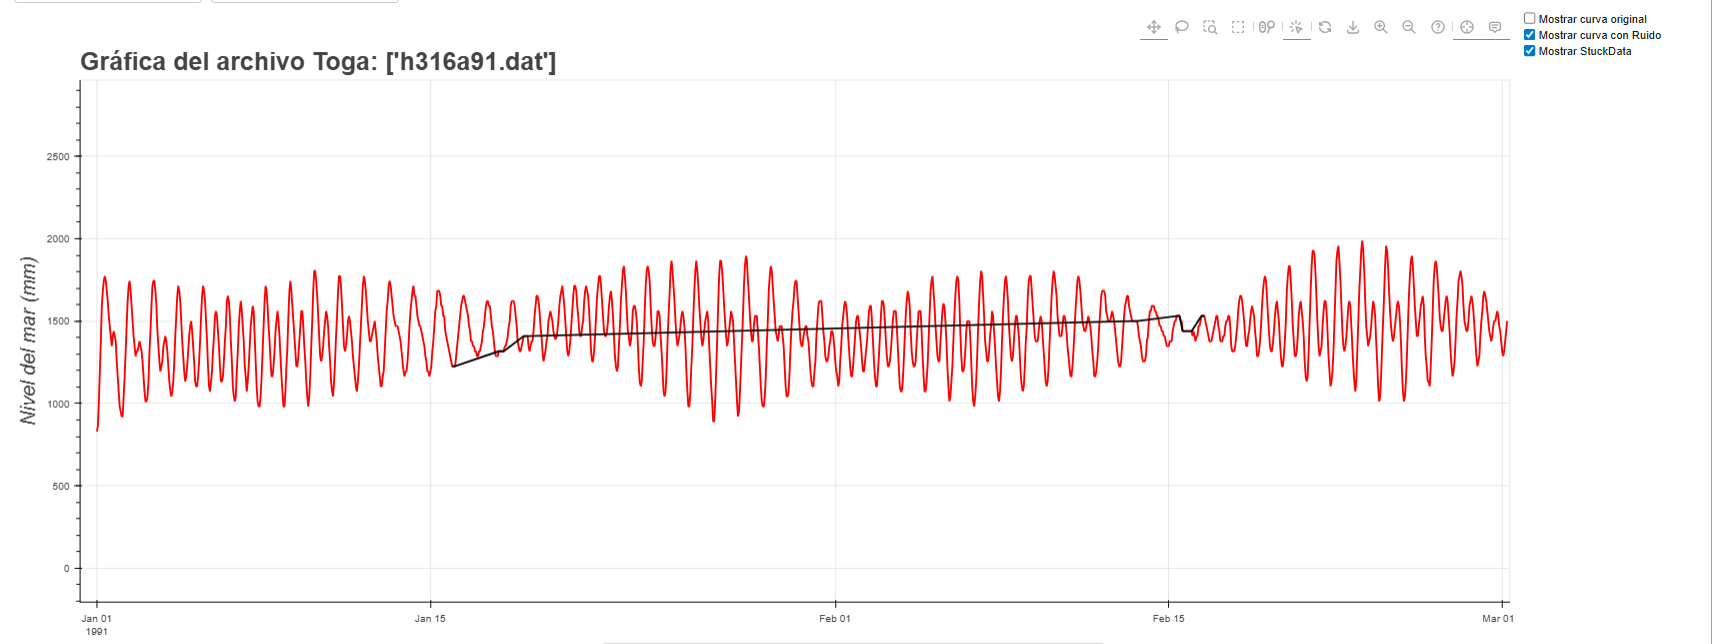


**Compatibilidad con Bokeh **



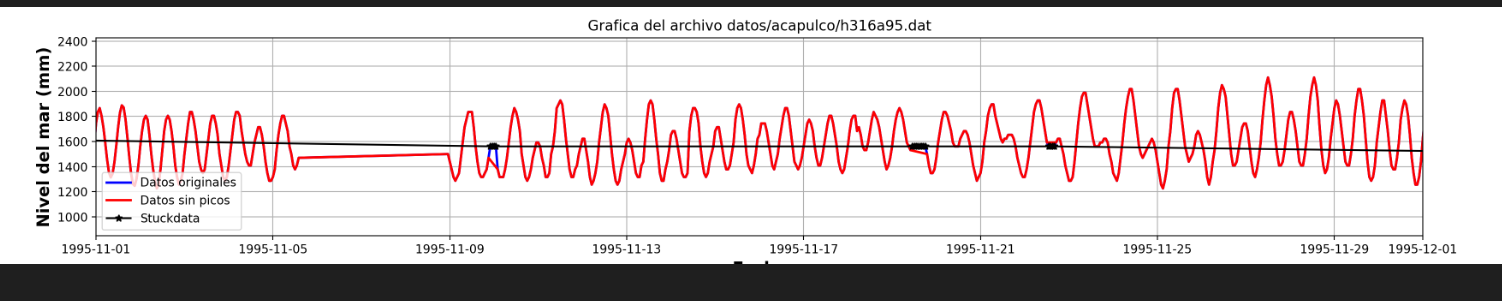

**ipywidgets** para interfaces
**Bokeh** uso para graficas y controles de google colab

**display(HTML(html))** es para incrustar mas cosas como tabs, HTML extra, widgets, botones, estilos, ideal para el control total sobre donde y como se inserta la grafica

**show(layout_final)** solo rederiza la grafica y la muestra,usar output_notebook() no siempre funciona cuando trabajamos con mas librerias distintas  

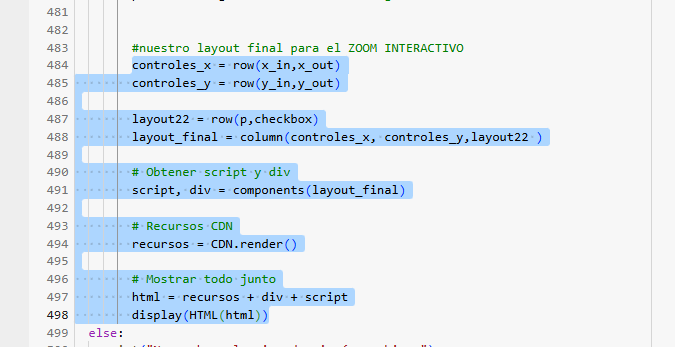

In [ ]:
import pandas as pd

# Datos ejemplo
texto = """
316A Acap  195401011 1158 1280 1402 1524 1585 1646 1615 1554 1494 1402 1341 1311
316A Acap  195401012 1311 1311 1341 1341 1311 1250 1189 1128 1036 1006 1006 1036
"""

filas = []
for linea in texto.strip().split('\n'):
    partes = linea.strip().split()
    codigo = partes[0]
    lugar = partes[1]
    fecha_str = partes[2]

    # Extraer fecha y franja
    fecha_real = fecha_str[:8]  # primeros 8 dígitos: YYYYMMDD
    franja = fecha_str[8:]      # último dígito: '1' o '2'

    valores = list(map(int, partes[3:] ))

    fila = {
        "Código": codigo,
        "Lugar": lugar,
        "Fecha": pd.to_datetime(fecha_real, format='%Y%m%d'),
        "Franja": franja
    }

    for i, v in enumerate(valores, 1):
        fila[f"H{i}"] = v

    filas.append(fila)

df = pd.DataFrame(filas)
print(df)


  Código Lugar      Fecha Franja    H1    H2    H3    H4    H5    H6    H7  \
0   316A  Acap 1954-01-01      1  1158  1280  1402  1524  1585  1646  1615   
1   316A  Acap 1954-01-01      2  1311  1311  1341  1341  1311  1250  1189   

     H8    H9   H10   H11   H12  
0  1554  1494  1402  1341  1311  
1  1128  1036  1006  1006  1036  
